# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.178912,False,1.287028
1,-0.702122,False,-2.648481
2,-0.054678,True,4.039794
3,-2.006925,False,-4.353708
4,1.091478,True,6.422243
...,...,...,...
995,1.286721,True,8.058466
996,-1.226529,False,-2.822882
997,-2.426674,False,-4.882726
998,-1.510994,False,-2.799771


<Axes: xlabel='v0'>

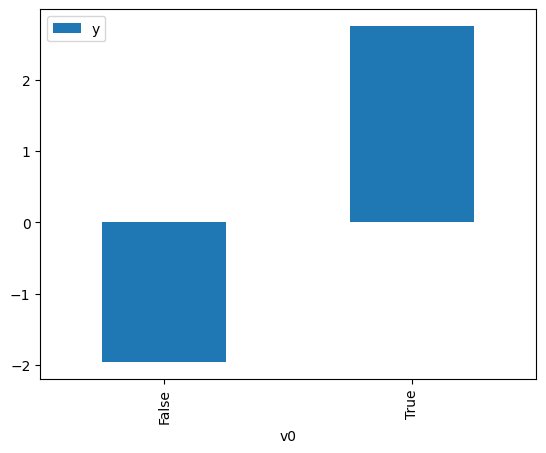

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

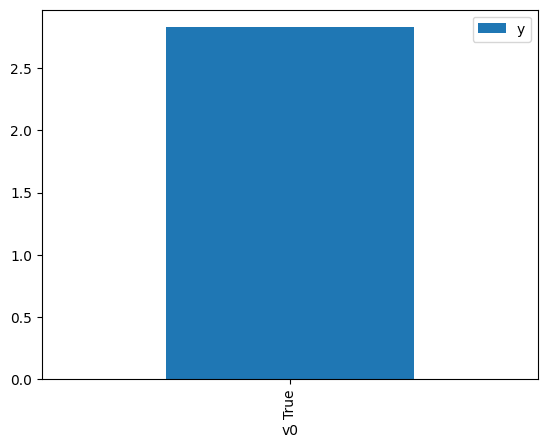

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.251662,False,-0.270584,0.397309,2.516931
1,-1.024733,False,-3.372255,0.893511,1.119180
2,0.112289,False,-0.401793,0.465325,2.149036
3,0.412502,False,0.449788,0.323608,3.090154
4,-2.568866,False,-6.890078,0.994538,1.005492
...,...,...,...,...,...
995,-1.216013,False,-1.735376,0.924724,1.081404
996,-0.901111,False,-4.025433,0.867696,1.152477
997,-1.606779,False,-4.064019,0.963984,1.037362
998,-0.556387,False,-1.760647,0.767406,1.303091


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.221267,True,4.463795,0.371488,2.691879
1,-0.925734,True,3.306578,0.126771,7.888251
2,-0.925734,True,3.306578,0.126771,7.888251
3,-1.843518,True,0.688138,0.022778,43.902294
4,-2.406016,True,0.120745,0.007540,132.625721
...,...,...,...,...,...
995,-2.406016,True,0.120745,0.007540,132.625721
996,-0.140228,True,5.305797,0.409911,2.439554
997,-2.406016,True,0.120745,0.007540,132.625721
998,-2.406016,True,0.120745,0.007540,132.625721


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.946
Model:                            OLS   Adj. R-squared (uncentered):              0.946
Method:                 Least Squares   F-statistic:                              8768.
Date:                Thu, 27 Jul 2023   Prob (F-statistic):                        0.00
Time:                        18:56:57   Log-Likelihood:                         -1415.4
No. Observations:                1000   AIC:                                      2835.
Df Residuals:                     998   BIC:                                      2845.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.4325      0.023    107.576      0.000       2.388       2.477
x2             5.0095      0.067     75.148      0.000       4.879       5.140
==============================================================================
Omnibus:                        2.805   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.246   Jarque-Bera (JB):                2.961
Skew:                           0.040   Prob(JB):                        0.228
Kurtosis:                       3.254   Cond. No.                         2.95
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""